In [1]:
import os
import random
import shutil

# Set up source and destination paths
source_folder = '/kaggle/input/vehicle-detection-8-classes-object-detection/train'
train_folder = '/kaggle/working/traindata'
test_folder = '/kaggle/working/testdata'
valid_folder = '/kaggle/working/validdata' 

In [2]:
# Create destination folders
for folder in [train_folder, test_folder, valid_folder]:
    os.makedirs(os.path.join(folder, 'images'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'labels'), exist_ok=True)


In [3]:
# Get list of image files
image_files = [filename for filename in os.listdir(os.path.join(source_folder, 'images')) if filename.endswith('.jpg')]

# Randomize the order of the image files
random.shuffle(image_files)

# Determine split sizes
train_size = int(0.7 * len(image_files))
test_size = int(0.15 * len(image_files))
valid_size = len(image_files) - train_size - test_size


In [4]:
# Copy images and labels to the destination folders
for i, filename in enumerate(image_files):
    image_path = os.path.join(source_folder, 'images', filename)
    label_path = os.path.join(source_folder, 'labels', filename.replace('.jpg', '.txt'))

    if i < train_size:
        destination_folder = train_folder
    elif i < train_size + test_size:
        destination_folder = test_folder
    else:
        destination_folder = valid_folder

    shutil.copy(image_path, os.path.join(destination_folder, 'images'))
    shutil.copy(label_path, os.path.join(destination_folder, 'labels'))


In [5]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.5/644.5 kB 9.7 MB/s eta 0:00:00a 0:00:01


In [6]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
#from IPython.core.magic import register_line_cell_magic
import yaml
from PIL import Image
import seaborn as sns 
from ultralytics import YOLO
from matplotlib.patches import Rectangle
import glob
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
num_classes = 8
classes = ['Motorcycle','Auto','Car','Bus','LCV(Light Motor Vehicle)','Truck','Tractor','Multi-Axle']


dict_file = {'train': os.path.join('/kaggle/working/', 'traindata'),
             'val': os.path.join('/kaggle/working/', 'validdata'),
             'test': os.path.join('/kaggle/working/', 'testdata'),
             'nc': num_classes,
             'names': classes
            }

with open(os.path.join('/kaggle/working/', 'vehicledata.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [9]:
class_idx = {str(i):classes[i] for i in range(num_classes)}

class_stat = {}
data_len = {}

for mode in ['traindata', 'validdata', 'testdata']:

    class_count = {classes[i]:0 for i in range(num_classes)}

    path = os.path.join('/kaggle/working/', mode, 'labels')

    for file in os.listdir(path):

        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1


    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count


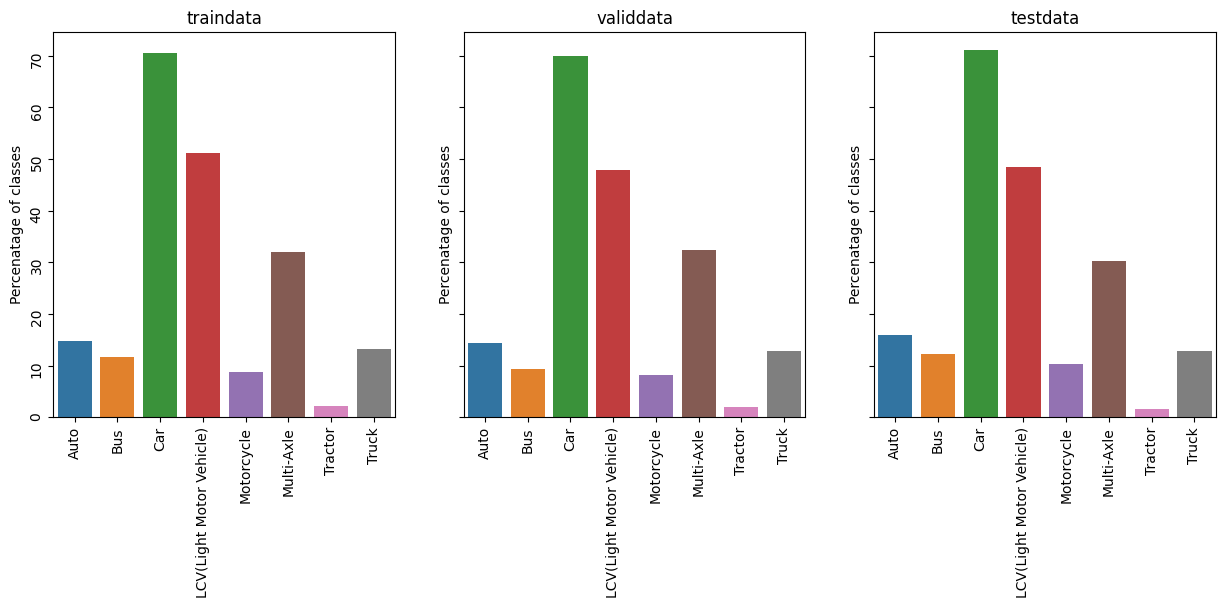

In [10]:
fig, ax = plt.subplots(1,3, figsize=(15, 5), sharey=True)

for i, mode in enumerate(['traindata', 'validdata','testdata']):
    sns.barplot(pd.DataFrame({mode:class_stat[mode]}).T/data_len[mode]*100, ax=ax[i])
    ax[i].set_title(mode)
    ax[i].tick_params(rotation=90)
    ax[i].set_ylabel('Percenatage of classes')
plt.show()

In [11]:
train_folder = '/kaggle/working/traindata/images'
test_folder = '/kaggle/working/testdata/images'
valid_folder = '/kaggle/working/validdata/images'
target_size = (640, 640)  

# Function to resize images in a folder
def resize_images_in_folder(folder_path):
    # Get list of image files
    image_files = [filename for filename in os.listdir(folder_path) if filename.endswith('.jpg')]

    # Resize images in the folder
    for filename in image_files:
        image_path = os.path.join(folder_path, filename)
        
        # Open the image using PIL
        image = Image.open(image_path)
        
        # Resize the image to the target size
        resized_image = image.resize(target_size)
        
        # Save the resized image
        resized_image.save(image_path)


In [12]:

# Resize images in the train folder
resize_images_in_folder(train_folder)

# Resize images in the test folder
resize_images_in_folder(test_folder)

# Resize images in the valid folder
resize_images_in_folder(valid_folder)


In [13]:
for mode in ['traindata', 'validdata', 'testdata']:
    print(f'\nImage sizes in {mode} set:\n')
    img_size = 0
    for file in glob.glob(os.path.join('/kaggle/working/', mode, 'images', '*')):
        image = Image.open(file)
        if image.size != img_size:
            print(f'\t{image.size}')
            img_size = image.size


Image sizes in traindata set:

	(640, 640)

Image sizes in validdata set:

	(640, 640)

Image sizes in testdata set:

	(640, 640)


In [14]:
for mode in ['traindata', 'validdata', 'testdata']:

    files =  glob.glob(os.path.join('/kaggle/working/', mode, 'images', '*'))

    print(f'{mode} set size: {len(files)}\n')


traindata set size: 5752

validdata set size: 1234

testdata set size: 1232



In [15]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 24.0MB/s]


In [16]:
model.train(data=os.path.join('/kaggle/working/','vehicledata.yaml'),
            task='detect',
            imgsz=640,
            epochs=30,
            batch=16,
            mode='train',
            name='yolov8n_v1_train')

Ultralytics YOLOv8.0.200 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/vehicledata.yaml, epochs=30, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v1_train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchsc

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
train: Scanning /kaggle/working/traindata/labels... 5752 images, 16 backgrounds, 0 corrupt: 100%|██████████| 5752/5752 [00:04<00:00, 1163.97it/s]
train: WARNING ⚠️ /kaggle/working/traindata/images/highway_2784_2020-08-26.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/traindata/images/highway_3297_2020-08-26.jpg: 1 duplicate labels removed
train: New cache created: /kaggle/working/traindata/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /kaggle/working/validdata/labels... 1234 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1234/1234 [00:00<00:00, 1344.42it/s]
val: New cache created: /kaggle/working/validdata/labels.cache
Plotting labels to runs/detect/yolov8n_v1_train/labels.jpg... 
optimizer: 'o

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f696c9677f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,

In [17]:
model = YOLO('/kaggle/working/runs/detect/yolov8n_v1_train/weights/best.pt')

In [18]:
results = model.predict(source=os.path.join('/kaggle/working/', 'testdata', 'images'), save=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1232 /kaggle/working/testdata/images/Highway_1001_2020-07-30_jpg.rf.70c4d63695312c6c33bdd45d7638425b.jpg: 640x640 2 Cars, 6.1ms
image 2/1232 /kaggle/working/testdata/images/Highway_1002_2020-07-30_jpg.rf.38a72727824ebdf2c817a5e4be6daa0e.jpg: 640x640 1 Car, 2 LCV(Light Motor Vehicle)s, 6.3ms
image 3/1232 /kaggle/working/testdata/images/Highway_1003_2020-07-30_jpg.rf.654d2fe251045a4a37654a3e3ed4d2c6.jpg: 640x640 1 Bus, 1 Multi-Axle, 6.2ms
image 4

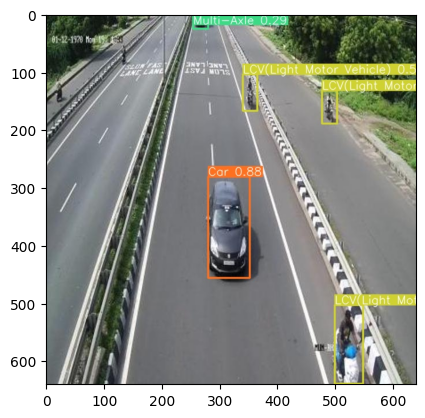

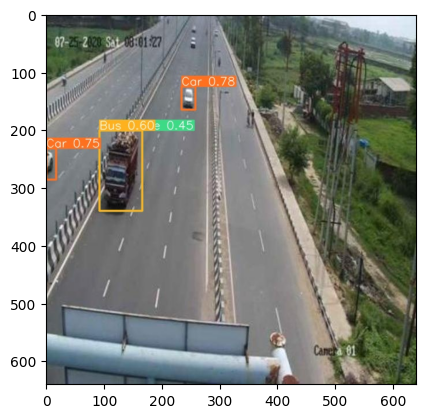

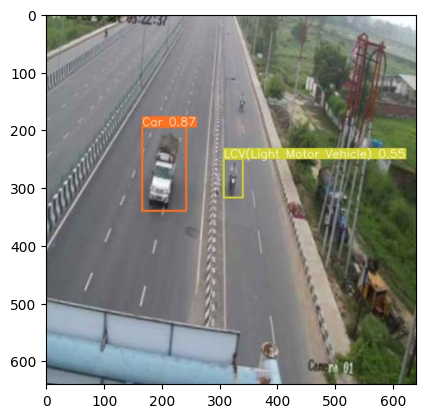

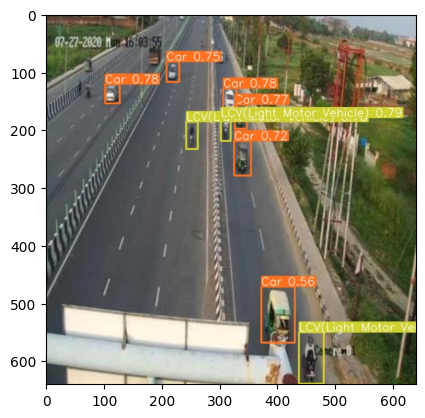

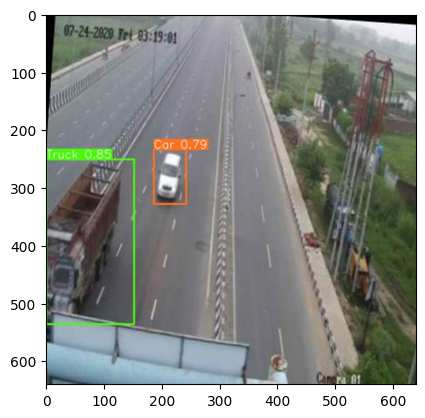

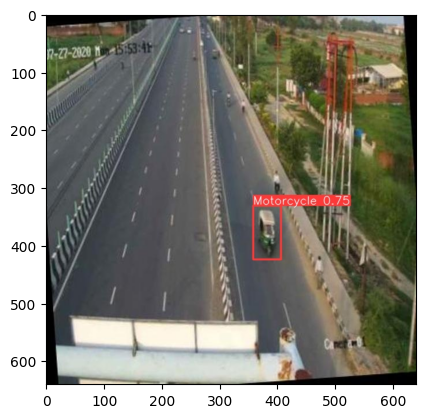

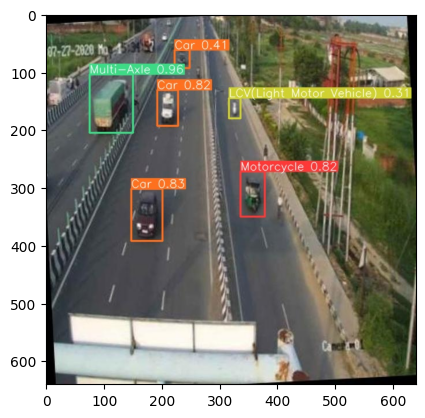

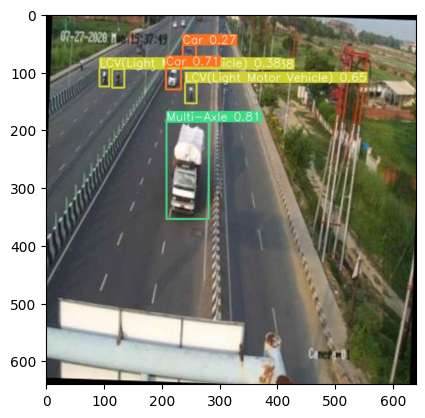

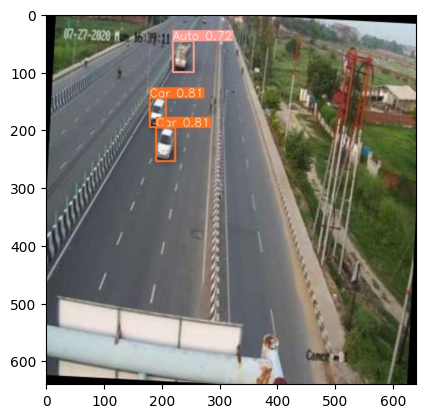

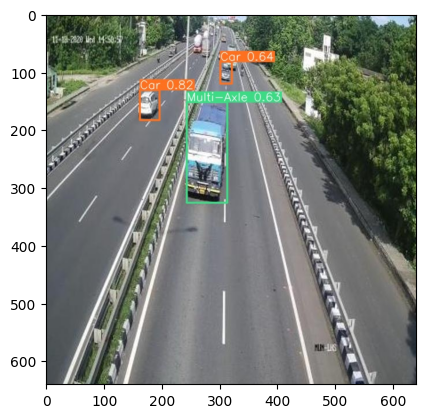

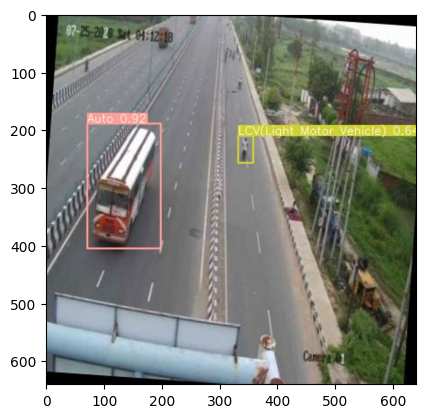

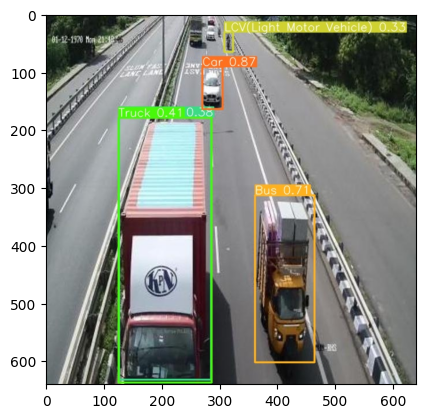

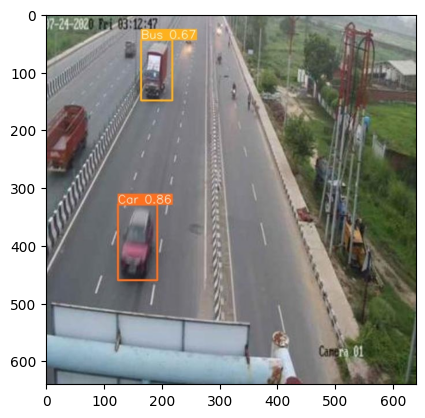

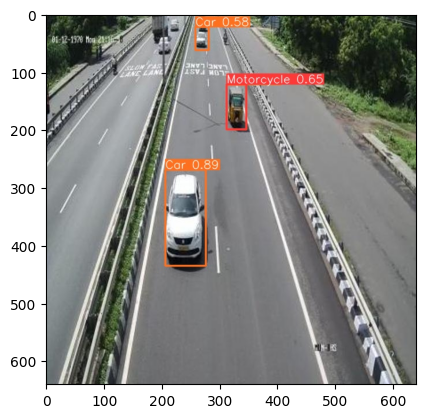

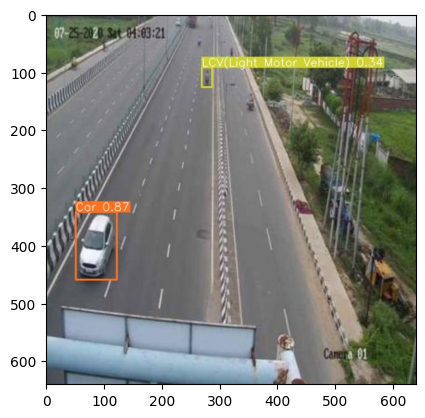

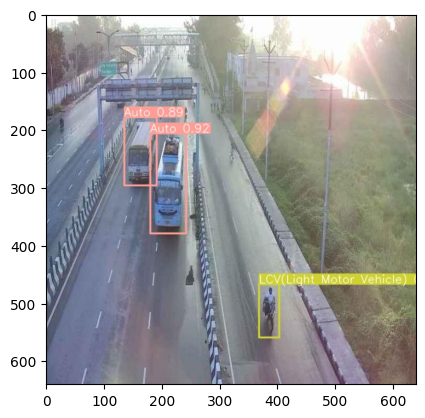

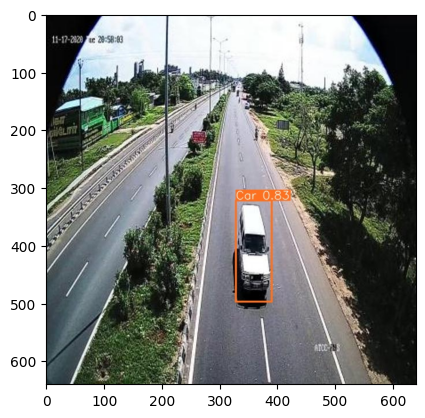

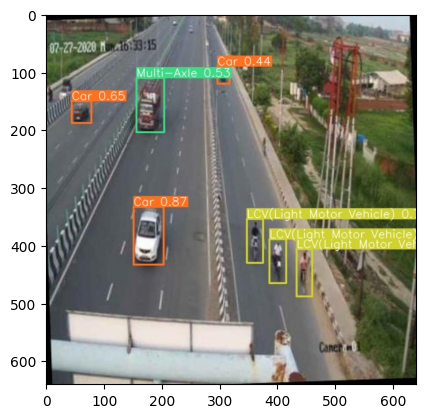

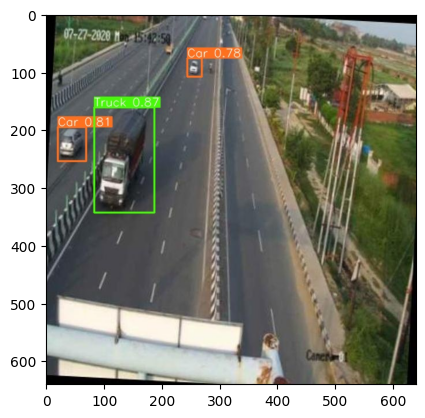

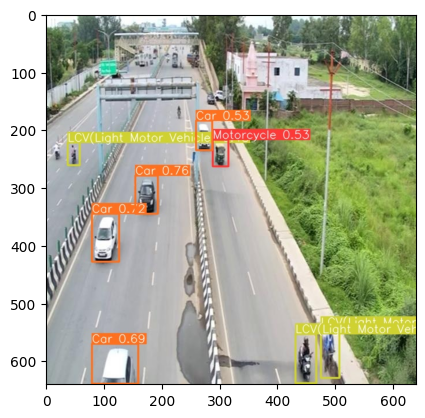

In [19]:
%matplotlib inline

predicitions = glob.glob(os.path.join('/kaggle/working/', 'runs/detect/predict', '*'))

n = 20

for i in range(n):
    idx = np.random.randint(0, len(predicitions))
    image = Image.open(predicitions[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()